In [1]:
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
################## pandas数据读取与处理

### 示例数据，电力负荷，前一天的29个值与预测日的5个气象值作为输入(34)，预测日的24个负荷值做输出(24)

# 读数据
data_full = pd.read_excel("/data1/zhangzt/dev/psolstm/dataset.xls")

# X和y
input = pd.concat([data_full.iloc[0,1:], data_full.iloc[1,1:6]])
output = data_full.iloc[0+1,6:]

for i in range(1, len(data_full) - 1):
    input = pd.concat([input, pd.concat([data_full.iloc[i,1:], data_full.iloc[i+1,1:6]])], axis=1, ignore_index=True)
    # X_full.append(data_full.iloc[i,1:].join(data_full.iloc[i+1,1:6], lsuffix='_pre', rsuffix='_current', how='inner'))
    output = pd.concat([output, data_full.iloc[i+1,6:]], axis=1, ignore_index=True)
    
X_full = input.T
y_full = output.T

# train,valid和test
X_train, y_train =  X_full.iloc[:len(X_full)-2,:], y_full.iloc[:len(y_full)-2,:]
X_valid, y_valid = X_full.iloc[-2,:], y_full.iloc[-2,:]
X_test, y_test = X_full.iloc[-1,:], y_full.iloc[-1,:]



In [ ]:
# constant
INPUT_SIZE = 34  # 定义输入的特征数
HIDDEN_SIZE = 64    # 定义一个LSTM单元有多少个神经元
BATCH_SIZE = 24   # batch
EPOCH = 10    # 学习次数
LR = 0.0001   # 学习率
# DROP_RATE = 0.2    #  drop out概率
LAYERS = 2         # 有多少隐层，一个隐层一般放一个LSTM单元
MODEL = 'LSTM'     # 模型名字
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [28]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 30, 64)
        pred = self.linear(output)  # (5, 30, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [23]:
m = LSTM(31,64,2,24,4)

In [27]:
X_train.columns

Index(['平均温度', '最高温度', '最低温度', '相对湿度', '星期类型', '0小时', '1小时', '2小时', '3小时',
       '4小时', '5小时', '6小时', '7小时', '8小时', '9小时', '10小时', '11小时', '12小时',
       '13小时', '14小时', '15小时', '16小时', '17小时', '18小时', '19小时', '20小时', '21小时',
       '22小时', '23小时', '平均温度', '最高温度', '最低温度', '相对湿度', '星期类型'],
      dtype='object')

In [3]:
# 针对每个镇街，feature包括第n-1天的24个整点的AQI，
# 风向，风力，风速，气温，湿度，气压，降雨量
# 输出为第n天的24个整点AQI
# 共31输入，24输出

<AxesSubplot:>

/data1/zhangzt/.conda/envs/p310-z/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  func(*args, **kwargs)
/data1/zhangzt/.conda/envs/p310-z/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  func(*args, **kwargs)
/data1/zhangzt/.conda/envs/p310-z/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data1/zhangzt/.conda/envs/p310-z/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


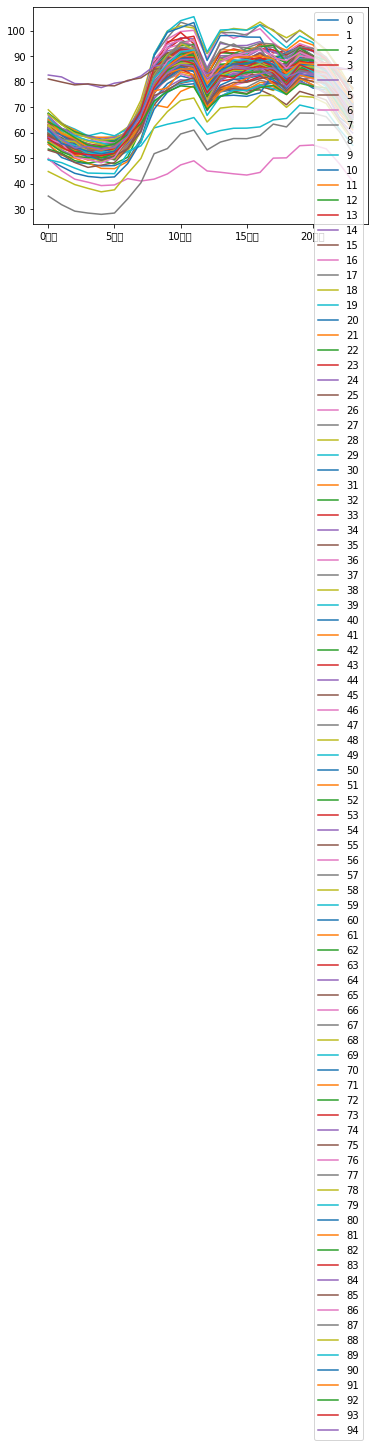

In [20]:
y_train.T.plot()

In [18]:
y_train.shape

(95, 24)

In [12]:
y_train.columns

Index(['0小时', '1小时', '2小时', '3小时', '4小时', '5小时', '6小时', '7小时', '8小时', '9小时',
       '10小时', '11小时', '12小时', '13小时', '14小时', '15小时', '16小时', '17小时', '18小时',
       '19小时', '20小时', '21小时', '22小时', '23小时'],
      dtype='object')

In [2]:
# lstm